In [1]:
import json 
import pandas as pd 
from pandas.io.json import json_normalize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split 

[nltk_data] Downloading package stopwords to /Users/ankit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ankit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df=pd.read_json('Downloads/uspto.json',lines=True)

In [3]:
objectdata=df.object.dropna().apply(pd.Series)

## Labelling the data as per their status

In [4]:
status=objectdata.status.unique()

In [5]:
status

array(['Publications -- Issue Fee Payment Verified',
       'Non Final Action Mailed', 'Awaiting TC Resp., Issue Fee Not Paid',
       'Final Rejection Mailed',
       'Docketed New Case - Ready for Examination', 'Patented Case',
       'Sent to Classification contractor',
       'Abandoned  --  Failure to Respond to an Office Action',
       'Advisory Action Mailed',
       "Examiner's Answer to Appeal Brief Mailed",
       'Response to Non-Final Office Action Entered and Forwarded to Examiner',
       'Patent Expired Due to NonPayment of Maintenance Fees Under 37 CFR 1.362',
       'Appeal Brief (or Supplemental Brief) Entered and Forwarded to Examiner',
       'Application Dispatched from Preexam, Not Yet Docketed',
       'RO PROCESSING COMPLETED-PLACED IN STORAGE',
       'PCT - International Search Report Mailed to IB',
       'Provisional Application Expired',
       'Application Undergoing Preexam Processing',
       'Expressly Abandoned  --  During Examination'], dtype=object)

In [6]:
approved=[status[5]]
approved

['Patented Case']

In [7]:
disapproval=[status[0],status[2],status[1],status[3],status[7],status[8],status[10],status[11],status[16],status[18],status[4],status[6],status[9],status[12],status[13],status[14],status[15],status[17]]
disapproval

['Publications -- Issue Fee Payment Verified',
 'Awaiting TC Resp., Issue Fee Not Paid',
 'Non Final Action Mailed',
 'Final Rejection Mailed',
 'Abandoned  --  Failure to Respond to an Office Action',
 'Advisory Action Mailed',
 'Response to Non-Final Office Action Entered and Forwarded to Examiner',
 'Patent Expired Due to NonPayment of Maintenance Fees Under 37 CFR 1.362',
 'Provisional Application Expired',
 'Expressly Abandoned  --  During Examination',
 'Docketed New Case - Ready for Examination',
 'Sent to Classification contractor',
 "Examiner's Answer to Appeal Brief Mailed",
 'Appeal Brief (or Supplemental Brief) Entered and Forwarded to Examiner',
 'Application Dispatched from Preexam, Not Yet Docketed',
 'RO PROCESSING COMPLETED-PLACED IN STORAGE',
 'PCT - International Search Report Mailed to IB',
 'Application Undergoing Preexam Processing']

In [8]:
objectdata['result']=[None for i in range(len(objectdata['status']))]

In [9]:
for i in range(len(objectdata['status'])):
    if objectdata['status'][i] in approved:
        objectdata['result'][i]=0
    elif objectdata['status'][i] in disapproval:
        objectdata['result'][i]=1

## Data Cleaning

In [10]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [11]:
def get_top_n_words(corpus, n=None,reverse=True):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=reverse)
    remwords= words_freq[:n]
    return [i[0] for i in remwords]

In [12]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #word_free = " ".join([i for i in normalized.split() if i not in common_words])
    #word_freehigh = " ".join([i for i in word_free.split() if i not in removewords])
    nonnumeric = re.sub(r"\d+","",normalized)
    processed = re.sub(r'\W*\b\w{1,4}\b',"",nonnumeric)
    #y = processed.split()
    return processed

In [14]:
objectdata['summary']=objectdata['summary'].apply(clean)

In [15]:
objectdata['title']=objectdata['title'].apply(clean)

In [16]:
common_words = get_top_n_words(objectdata['summary']+objectdata['title'],30)

In [17]:
common_words

['lidar',
 'system',
 'laser',
 'signal',
 'light',
 'method',
 'point',
 'target',
 'optical',
 'object',
 'source',
 'pulse',
 'image',
 'sensor',
 'using',
 'includes',
 'measurement',
 'first',
 'second',
 'detection',
 'device',
 'surface',
 'système',
 'position',
 'detector',
 'invention',
 'array',
 'information',
 'configured',
 'reflected']

In [18]:
def removewords(doc):
    word_free = " ".join([i for i in doc.split() if i not in common_words])
    return word_free

In [19]:
objectdata['summary']=objectdata['summary'].apply(removewords)
objectdata['title']=objectdata['title'].apply(removewords)

## Sorting by Date & Time

In [20]:
objectdata['filingDate']=objectdata['filingDate'].apply(lambda x: np.NaN if (len(x)<1) else x)

In [21]:
objectdata['filingDate']=objectdata['filingDate'].apply(lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %z %Y") if isinstance(x,str) else x) 

In [22]:
objectdata=objectdata.sort_values(by='filingDate')

In [23]:
objectdata=objectdata.reset_index(drop=True)

In [24]:
objectdata.head(10)

,id,title,summary,status,filingDate,publicationNumber,publicationDate,objectType,result
0,06248629,removal background backscattering subtraction ...,,Patent Expired Due to NonPayment of Maintenanc...,1981-03-27 13:00:00+00:00,NaN,,patent,1
1,07146093,control photomultiplier detecting differential...,,Patented Case,1988-01-20 13:00:00+00:00,NaN,,patent,0
2,07216341,imaging,,Patented Case,1988-07-07 11:00:00+00:00,NaN,,patent,0
3,07256778,imaging nonvisible,,Patent Expired Due to NonPayment of Maintenanc...,1988-10-12 11:00:00+00:00,NaN,,patent,1
4,07348746,,,Expressly Abandoned -- During Examination,1989-05-08 11:00:00+00:00,NaN,,patent,1
5,07364860,incorporating multiple camera obtaining plural...,,Patent Expired Due to NonPayment of Maintenanc...,1989-06-12 11:00:00+00:00,NaN,,patent,1
6,07416652,arrangement measuring atmospheric turbidity,,Patented Case,1989-10-03 11:00:00+00:00,NaN,,patent,0
7,07420247,imaging,,Patented Case,1989-10-12 11:00:00+00:00,NaN,,patent,0
8,07499068,scanning,,Patented Case,1990-03-23 13:00:00+00:00,NaN,,patent,0
9,07539230,midinfrared hydrocarbon,,Patented Case,1990-06-18 11:00:00+00:00,NaN,,patent,0


## Creating TfIdf Sparse Matrices

In [25]:
vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
vectorizer2 = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
summary = vectorizer.fit_transform(objectdata['summary'])
title=vectorizer2.fit_transform(objectdata['title'])

In [26]:
summary.shape

(358, 11091)

In [27]:
title.shape

(358, 1156)

## Cosine Similarity of a document with all other documents

In [28]:
def cosine_similarity(x,y):
    return y.dot(x.T)

## Predicting status based on Similarity with historical data of Patents

In [29]:
def predict(doc):
    doc['title']=doc['title'].apply(clean)
    doc['summary']=doc['summary'].apply(clean)
    doc['title']=doc['title'].apply(removewords)
    doc['summary']=doc['summary'].apply(removewords)
    docsum=vectorizer.transform(doc['summary'])
    doctitle=vectorizer2.transform(doc['title'])
    similar_titles=cosine_similarity(title,doctitle[0]).toarray()
    similar_summary=cosine_similarity(summary,docsum[0]).toarray()
    simtitle={}
    for x,i in np.ndenumerate(similar_titles):
        if i>0.5:
            simtitle[x[1]]=i
    simsum={}
    for x,i in np.ndenumerate(similar_summary):
        if i>0.5:
            simsum[x[1]]=i
    if len(simtitle)>0:
        for i in simtitle.keys():
            if objectdata.loc[i,'result']==0:
                return 1
    if len(simsum)>0:
        for i in simsum.keys():
            if objectdata.loc[i,'result']==0:
                return 1
    return 0

## Performance

In [30]:
trainX, testX, trainy, testy = train_test_split(objectdata.iloc[:,:-1],objectdata['result'], test_size=0.3, random_state=2)

In [31]:
trainX=trainX.reset_index(drop=True)
trainy=trainy.reset_index(drop=True)
testX=testX.reset_index(drop=True)
testy=testy.reset_index(drop=True)

In [32]:
summary = vectorizer.fit_transform(trainX['summary'])
title=vectorizer2.fit_transform(trainX['title'])

In [33]:
def predict(doc,i):
    doc['title']=doc['title'].apply(clean)
    doc['summary']=doc['summary'].apply(clean)
    doc['title']=doc['title'].apply(removewords)
    doc['summary']=doc['summary'].apply(removewords)
    docsum=vectorizer.transform(doc['summary'])
    doctitle=vectorizer2.transform(doc['title'])
    similar_titles=cosine_similarity(title,doctitle[i]).toarray()
    similar_summary=cosine_similarity(summary,docsum[i]).toarray()
    simtitle={}
    for x,i in np.ndenumerate(similar_titles):
        if i>0.5:
            simtitle[x[1]]=i
    simsum={}
    for x,i in np.ndenumerate(similar_summary):
        if i>0.5:
            simsum[x[1]]=i
    if len(simtitle)>0:
        for i in simtitle.keys():
            if trainy[i]==0:
                return 1
    if len(simsum)>0:
        for i in simsum.keys():
            if trainy[i]==0:
                return 1
    return 0

In [34]:
y_pred=[]
for i in range(len(testX)):
    y_pred.append(predict(testX,i))

In [35]:
len(testy)

108

In [36]:
len(y_pred)

108

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(list(testy),y_pred))
print(classification_report(list(testy),y_pred))

[[33 12]
 [42 21]]
              precision    recall  f1-score   support

           0       0.44      0.73      0.55        45
           1       0.64      0.33      0.44        63

   micro avg       0.50      0.50      0.50       108
   macro avg       0.54      0.53      0.49       108
weighted avg       0.55      0.50      0.48       108



In [38]:
from sklearn.metrics import r2_score,mean_squared_error,roc_curve,auc
import matplotlib.pyplot as matplot_plt
def get_roc (y_test,y_pred):
  
    #True Vs Predicted Value
    print("RMSE")
    print(mean_squared_error(y_test,y_pred))
    
    print("\n R(Square)")
    print(r2_score(y_test,y_pred))
    
    # Compute ROC curve and ROC area for each class
    false_positive_ratio = dict()
    true_positive_ratio = dict()
    #Results Computed------
    roc_auc = dict()
    
    #Results Computed------
    for i in range(2):
        false_positive_ratio[i], true_positive_ratio[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(false_positive_ratio[i], true_positive_ratio[i])
    
    
    
    #Plot of a ROC curve
    matplot_plt.figure()
    lw = 2
    matplot_plt.plot(false_positive_ratio[1], true_positive_ratio[1], color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc[1])
    matplot_plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    
    #Results Computed------
    
    matplot_plt.xlim([0.0, 1.0])
    matplot_plt.ylim([0.0, 1.0])
    
    
    matplot_plt.xlabel('False Positive Rate')
    matplot_plt.ylabel('True Positive Rate')
    matplot_plt.title('Receiver operating characteristic')
    matplot_plt.legend(loc="lower right")
    matplot_plt.show()
    return

RMSE
0.5

 R(Square)
-1.057142857142857


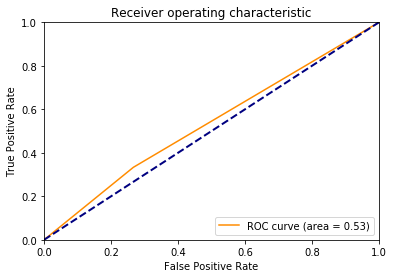

In [39]:
get_roc(list(testy),y_pred)

## API

In [ ]:
from flask import Flask,request
  
app = Flask(__name__) 
  
@app.route('/patentpredict', methods=["POST"]) 
def predict_patent(): 
    req = request.get_json()
    doc=pd.DataFrame(req['object'],index=[0])
    res=predict(doc)
    if res==0:
        return "Approved"
    elif res==1:
        return "Not approved"

@app.route('/patentrecord',methods=["POST"])
def record_patent():
    req = request.get_json()
    doc=pd.DataFrame(req['object'],index=[0])
    if doc['status'] in approved:
        doc['result']=[0]
    elif doc['status'] in disapproval:
        doc['result']=[1]
    objectdata.append(doc)
    return "Submitted"
if __name__ == '__main__': 
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
